In [1]:

import pandas as pd
import numpy as np

x_train_n = pd.DataFrame({'fruit_label':[0,    1,    0,    1,    0,    1,    0,    1,    0,    1,    0,    1], 
                      'mass':       [154,  260,  148,  218,  150,  142,  148,  316,  148,  148,  152,  198],
                      'width':      [6.15, 7.55, 6.55, 7.05, 5.95, 5.97, 5.85, 8.52, 6.45, 6.08, 6.35, 6.87]}).values
y_train_n = pd.DataFrame({'color_score':[35,   46,   34,   46,   27,   52,   28,   49,   28,   60,   28,   64]}).values


x_val_n  = pd.DataFrame({'fruit_label':[0,    1,    0,    1,    0,    1,    0,    1,    0,    1,    0,    1], 
                      'mass':       [150,  120,  154,  148,  154,  196,  154,  164,  150,  142,  144,  262],
                      'width':      [6.15, 5.53, 6.65, 6.17, 7.15, 6.48, 6.35, 5.93, 5.75, 6.08, 5.70, 7.58]}).values
y_val_n = pd.DataFrame({'color_score':[24,   47,   31,   46,   42,   58,   27,   49,   19,   61,   26,   50]}).values


print('x_train_n',x_train_n.shape, 'x_val_n',x_val_n.shape, 'y_train_n',y_train_n.shape, 'y_val_n',y_val_n.shape)


x_train_n (12, 3) x_val_n (12, 3) y_train_n (12, 1) y_val_n (12, 1)


In [2]:
import random as rn
import lightgbm as lgb
import numpy as np

class TrainLGB():
    model = None
    conf = None
    history_callback = None

    def __init__(self, conf):
        self.conf = conf
        #print('lgb init done')
        return

    def compile(self, x_train_shape):
        #print('lgb define done')
        return

    def fit(self, x_train, y_train, x_val, y_val):
        lgb_train = lgb.Dataset(x_train, label=y_train.reshape(-1))
        lgb_val = lgb.Dataset(x_val, label=y_val.reshape(-1))

        evals_result = {}
        c=self.conf
        #params = {'metric':'mape', 'num_threads': -1, 'objective': 'regression', 'verbosity': 1} # rmse
        params = {'lambda_l2':3,'metric':c['metric'], 'num_threads':c['num_threads'], 'objective': c['objective'], 'verbosity': c['verbosity'], 'is_training_metric': True,} # rmse
        rounds = c['rounds']
        # https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html
        self.model = lgb.train(
            params = params, 
            #lgb_train, 
            train_set = lgb_train, 
            num_boost_round = rounds, 
            valid_sets = [lgb_train,lgb_val], 
            verbose_eval=c['verbose_eval'], 
            early_stopping_rounds=c['early_stopping_rounds'], 
            callbacks=[lgb.record_evaluation(evals_result)] #same -> evals_result=evals_result,
            #callbacks=[lgb.print_evaluation(period=1, show_stdv=True)] #same -> evals_result=evals_result,
        )
        steps = self.model.best_iteration #print(f"Best: {steps}") #print('lgb fit done')
        self.history_callback = evals_result
        return

    def predict(self, x):
        #print('lgb predict done')
        return self.model.predict(x)
    
    def get_costs(self):
        ox_list = [x for x in range(1,self.conf['rounds']+1)]
        oy_train_list = self.history_callback['training']['mape']
        oy_train_list = list(np.array(oy_train_list, dtype=np.float32))
        oy_val_list = self.history_callback['valid_1']['mape']
        oy_val_list = list(np.array(oy_val_list, dtype=np.float32))
        title = 'rounds='+str(self.conf['rounds'])
        #title = str(self.conf)
        return {'ox_list':ox_list, 'oy_train_list':oy_train_list, 'oy_val_list':oy_val_list, 'title':title}

 
            

conf_i = {
        "name":"lgb",
        "tune":"rs,rounds",
        "rs":2734,
        "metric":"mape", 
        "num_threads": -1, 
        "objective": "regression", 
        "verbosity": 1,
        "rounds":3,
        "verbose_eval":100,
        "early_stopping_rounds":2000
    }
model = TrainLGB(conf_i)
model.compile(x_train_n.shape)
model.fit(x_train_n, y_train_n, x_val_n, y_val_n)

print(model.history_callback)

#final_model.feature_importance()
#loss_history = history_callback.history["loss"]
#history_callback.history
y_train_pred_n = model.predict(x_train_n) 
#model.model.evals_result_


#history_callback['training']['mape']
#type(model.get_costs()['oy_train_list'][0])
#model.get_costs()
#list(np.array(model.get_costs()['oy_train_list'], dtype=np.float32))

Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[1]	training's mape: 1.19213	valid_1's mape: 1.36712
{'training': OrderedDict([('mape', [1.1921285819762169, 1.1921285819762169, 1.1921285819762169])]), 'valid_1': OrderedDict([('mape', [1.3671220978571574, 1.3671220978571574, 1.3671220978571574])])}


In [5]:
y_train_pred_n.shape

(12,)

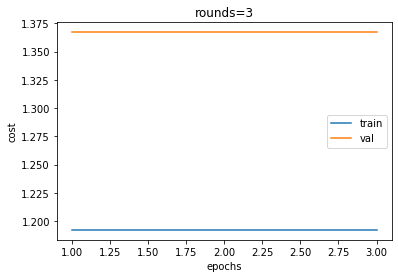

In [4]:
def plot_costs(ox, train_list, val_list, title):
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.plot(ox, train_list); 
    plt.plot(ox, val_list); 
    plt.ylabel('cost'); 
    plt.xlabel('epochs'); 
    plt.title(title); 
    plt.legend(['train','val'])
    plt.show()  
#plot_costs(ox=[x for x in range(1,conf_i['epochs']+1)], train_list=history_callback.history["loss"], val_list=history_callback.history["val_loss"])
#plot_costs(model.get_costs())
#plot_costs([1,2,3],[1,2,3],[1,2,3],'tit')
#plot_costs([1, 2, 3],[1.1921285, 1.1921285, 1.1921285],[1.1921285, 1.1921285, 1.1921285],'epochs=3')

c = model.get_costs()
plot_costs(c['ox_list'],c['oy_train_list'],c['oy_val_list'],c['title'])
        
    

